# CNN pruning and quantization




Quantization allows for decreasing data memory size necessary to store them.

Also allows for faster computation with dedicated devices like embedded GPU and FPGA.

Applying quantization on continues data creates regions of attraction.

Values from some range are assigned to proper value that represents that range.

That also increase the level of correlation between quantized filters, 

so allows for more effective pruning.

That results with much more smaller network than at the beginning.  

In [3]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists
1.13.0+cu117


In [2]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Dict
from copy import deepcopy

# local_utils file contains util functions for training or display
# CHECK IT
import local_utils as lu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def set_random_seed(seed:int = 0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    

cuda


Datasets

len(train_loader) = 938
len(test_loader) = 157
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 432x288 with 0 Axes>

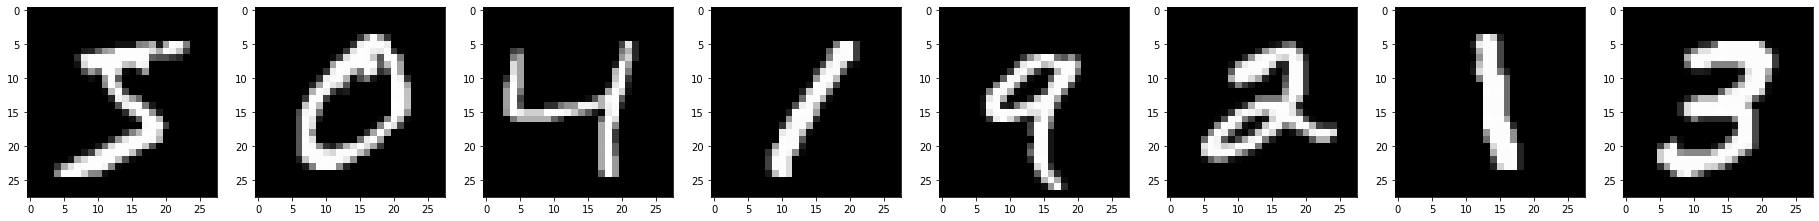

In [4]:
from torchvision.transforms import ToTensor

BATCH_SIZE = 64
set_random_seed(0)

train_dataset = datasets.MNIST('data', 
                              train=True,
                              download=True,
                              transform=ToTensor())
test_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)
test_loader = DataLoader(test_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print("len(train_loader) =", len(train_loader))
print("len(test_loader) =", len(test_loader))

plt.gray()
loader = train_loader
for X, y in loader:
    print(X.shape)
    print(y.shape)
    
    ROWS, COLS = 1, 8
    fig, axs = plt.subplots(ROWS, COLS)
    fig.set_size_inches(COLS*4,ROWS*4)
    axs = np.array(axs).flatten().tolist()
    
    for i, ax in enumerate(axs):
        img = X[i,...]
        class_label = loader.dataset.classes[y[i]]
        ax.imshow(img.permute(1,2,0))
    plt.show()
    break

Network definition and training

Run network training - it spends very long time, so for only your code check you can run only one epoch.

When you check your code back to 30 epochs :) .

In [5]:
from brevitas.nn import QuantConv2d, QuantIdentity
from brevitas.quant.scaled_int import Int8WeightPerTensorFloat, \
    Int8BiasPerTensorFloatInternalScaling, Int8ActPerTensorFloat


class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_shape=(1,28,28), 
                 num_of_classes=10,
                 channels = [16,32,64,128], # number of conv filters 
                 ksize   =  [3, 3, 3, 3], # kernels sizes
                 padding =  [1, 1, 0, 0], # padding sizes
                 max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                 quantize=True,
                 bit_width=4
                 ) -> None:
        super().__init__()
        channels = [input_shape[0]]+channels
        padding = [1,1,0,0]
        max_pool = [1,1,0,0]
        
        if quantize:
            input_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0, bit_width=bit_width)
        else:
            input_quant = QuantIdentity(None)
        
        layers = []
        self.conv_layers = []
        map_shape = [input_shape[0],input_shape[1],input_shape[2]]
        for i, (ch_in, ch_out, ks, p, mp) in enumerate(zip(channels[:-1],
                                                       channels[1:],
                                                       ksize,
                                                       padding,
                                                       max_pool)):
            conv = QuantConv2d(ch_in, ch_out, ks, padding=p, bias=True, 
                               weight_quant=Int8WeightPerTensorFloat if quantize else None,
                               bias_quant=Int8BiasPerTensorFloatInternalScaling if quantize else None,
                               weight_bit_width=bit_width,
                               bias_bit_width=bit_width,
                               return_quant_tensor=False
                               )
            # shape modification
            map_shape[0] = ch_out
            map_shape[1] = map_shape[1] - 2*(ks//2 - p)
            map_shape[2] = map_shape[2] - 2*(ks//2 - p)
            
            # store conv layers for further analysis and prunning
            self.conv_layers.append(conv)
            # add to all layers
            layers.append(conv)
            
            if quantize:
                out_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0, bit_width=bit_width)
            else:
                out_quant = QuantIdentity(None)
            
            layers.append(out_quant)
            relu = nn.ReLU()
            layers.append(relu)
            
            if mp:
                maxpool = nn.MaxPool2d(2,2)
                # shape modification
                map_shape[1] = map_shape[1] // 2
                map_shape[2] = map_shape[2] // 2
                layers.append(maxpool)
        
        self.CNN = nn.Sequential(input_quant, *tuple(layers))
        
        CNN_flatten_len = torch.prod(torch.tensor(map_shape))
        print(f"CNN out map shape = {map_shape}")
        print(f"CNN out map numel = {CNN_flatten_len}")
        self.flatten = nn.Flatten()
        self.FC = nn.Linear(CNN_flatten_len, num_of_classes)
        self.sm = nn.Softmax(1)
    
    def forward(self, x: torch.Tensor):
        x = self.CNN(x)
        x = self.flatten(x)
        x = self.FC(x)
        x = self.sm(x)
        return x

set_random_seed(0)
net = NeuralNetwork(input_shape=(1,28,28), 
                    num_of_classes=10,
                    channels = [32,32,32,32], # number of conv filters 
                    ksize   =  [3, 3, 3, 3], # kernels sizes
                    padding =  [1, 1, 0, 0], # padding sizes
                    max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                    quantize=True
                    ).to(device)
net_param_number = lu.count_params(net)
print(f"Network paramerters number: {net_param_number}")

set_random_seed(0)
metric = lu.AccuracyMetic()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.8, weight_decay=0.0001)

set_random_seed(0)
net, history = lu.training(net, train_loader, test_loader, criterion, metric, optimizer, 5, 1, device=device)

CNN out map shape = [32, 3, 3]
CNN out map numel = 288
Network paramerters number: 30959
Epoch 1 / 1: STARTED
TRAINING

938it [00:21, 44.11it/s]


VALIDATION

157it [00:02, 58.77it/s]

After epoch 1: loss=1.9598 acc=0.5037 val_loss=1.7891 val_acc=0.6712
Epoch 1 / 1: FINISHED



1. Extract state dict from each conv layer (`net.conv_layers` is a list of Conv2d submodules) and store it in a list `state_dicts_float`.

Create second list `state_dicts_quant` with the same structure, 

but extract weights and biases after applied quantization (`.quant_weight()`, `.quant_bias()` -> `QuantTensor` - extract float tensor from it).

Also create `state_dicts_quant_2` as a copy of `state_dicts_quant` elements - deep copy.

Print layer index (in list) and shapes of weights and biases.

Extract state dict of FC subnetwork. 
Store it as `sd_fc` and copy to `sd_fc_2`. 
Print weight and bias shapes for FC layer.


Compare (display Sum of Absolute Difference value) weight for first convolution before(float) and after quantization.

Note: state dict of Conv2d and QuantConv2d contains: `weight` and `bias` (optional) keys only.

Remember about `torch.no_grad()` context

In [6]:

state_dicts_float: List[Dict[str, torch.Tensor]] = []
state_dicts_quant: List[Dict[str, torch.Tensor]] = []
state_dicts_quant_2: List[Dict[str, torch.Tensor]] = []
sd_fc = net.FC.state_dict()
sd_fc_2 = sd_fc

with torch.no_grad():
    for i, L in enumerate(net.conv_layers):
        L: QuantConv2d = L
        state_dicts_float.append({"state": L.state_dict})
        state_dicts_quant.append({"weight": L.quant_weight()[0], "bias" : L.quant_bias()[0]})

        print(f"weight_{i} = {L.quant_weight()}, shape = {L.quant_weight().shape},\nbias_{i} = {L.quant_bias()}, shape = {L.quant_bias().shape}")

    state_dicts_quant_2 = deepcopy(state_dicts_quant)

print(sd_fc["weight"].shape)



weight_0 = QuantTensor(value=tensor([[[[-0.0000,  0.1627, -0.2440],
          [-0.2440, -0.1627,  0.0813],
          [ 0.0000,  0.2440, -0.0000]]],


        [[[ 0.0813, -0.0813, -0.0813],
          [-0.3253, -0.2440, -0.0813],
          [ 0.0000,  0.1627,  0.2440]]],


        [[[-0.1627, -0.0813,  0.2440],
          [ 0.3253,  0.0000,  0.4067],
          [-0.0813,  0.0813,  0.4067]]],


        [[[-0.3253, -0.2440, -0.0813],
          [-0.1627,  0.3253, -0.2440],
          [-0.1627, -0.2440, -0.3253]]],


        [[[-0.1627,  0.3253,  0.2440],
          [ 0.2440,  0.0813, -0.1627],
          [ 0.0813, -0.3253, -0.3253]]],


        [[[-0.1627,  0.4067,  0.4067],
          [-0.0813,  0.1627,  0.4880],
          [ 0.4067,  0.3253,  0.2440]]],


        [[[ 0.2440, -0.1627,  0.0813],
          [-0.2440, -0.2440, -0.1627],
          [ 0.1627,  0.1627, -0.1627]]],


        [[[ 0.1627,  0.2440, -0.0813],
          [ 0.0813,  0.1627,  0.2440],
          [ 0.4067, -0.1627, -0.0813]]],


   

In [7]:
def get_mask(parameter: torch.Tensor, threshold: float):
    """
    Function returns the mask of filters which should not be removed. 

    :param parameter: weight tensor with shape = (num_of_filters, input_channels, Optional[kernel_height, kernel_width]]
    :param threshold float: threshold value - cos of "angle" between filters 
    :return: tensor - bool mask
    """
    original_shape = parameter.shape
    parameter = parameter.reshape(original_shape[0],-1)
    parameter = parameter / (parameter.square().sum(1).reshape(-1,1).sqrt())
    
    # correlation matrix
    corr = torch.matmul(parameter, parameter.transpose(0,1))
    
    # highly correlated filters mask 
    corr_mask = corr.abs() > threshold

    # print(corr.shape)
    
    # over diagonal matrix
    row_idx, col_idx = torch.meshgrid(torch.arange(0,corr.shape[0]), torch.arange(0,corr.shape[0]),)
    analysis_mask = col_idx > row_idx
    
    # over diagonal part of mask
    filters_correlation = corr_mask * analysis_mask.to(parameter.device)

    channels_mask = filters_correlation.sum(0) == 0
    
    return channels_mask


2. Calculate pruning masks (`get_mask`) for each quantized weights from `state_dicts_quant` list.

Store them in list `masks`.

Calculate number of filters of convolutional layers after pruning for each layer

and print it.

Use thresholds for next CNN layers: `thresholds = [0.5, 0.5, 0.5, 0.5]`

Hint: work on copy of weights - `torch.Tensor.clone` 

In [8]:
masks: List[torch.Tensor] = []
num_of_filters_after_pruning = nofp = []
thresholds = [0.5, 0.5, 0.5, 0.5]

for i, (sd_q, th) in enumerate(zip(state_dicts_quant, thresholds)):
    w = sd_q['weight']
    mask = get_mask(w, th)
    
    masks.append(mask)
    num_of_filters_after_pruning.append(mask.sum())
    
    print(f"Layer {i}: filters after pruning: {nofp[i]}")

Layer 0: filters after pruning: 5
Layer 1: filters after pruning: 32
Layer 2: filters after pruning: 26
Layer 3: filters after pruning: 31


/home/lsriw/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


3. Slice weights and biases from `state_dicts_quant` based on created `masks`.

Results assign to proper indices and keys of `state_dicts_quant_2`.

Slice weight of fc layer from `sd_fc` and result assign to `sd_fc_2` based on last mask.

Print shapes of weights and biases.

Note: Pruning of channels one layer affects to next one layer, but not to the previous layer.

Note: bias is related with layer output channel.

Note: first layer must contain the same number of input channels.

Hint: For slicing of few dimensions, use it separately on results of previous dim slice.

Hint: Do it in loop: store mask for previous mask as variable like `prev_mask`.

For init `prev_mask` use tensor of True and shape (1,) - input channels.

Note: Fc layer is forwarded by flatten layer ((BS,CH,H,W) -> (BS, CH * H * W)), 

so the input mask should be properly modified:

```fc_in_mask = prev_mask.reshape(-1,1,1).tile(1,H,W).flatten()```

CH,H,W sizes are printed, when the network is instantiated. 

In [9]:
prev_mask = torch.ones((1,), dtype=torch.bool, device=device)

for i, (mask, sd_q, sd_q_2) in enumerate(zip(masks, state_dicts_quant, state_dicts_quant_2)):
    w = sd_q["weight"][mask, :][:, prev_mask]
    b = sd_q["bias"][mask]

    sd_q_2["weight"] = w
    sd_q_2["bias"] = b

    print(f"Layer {i}: weight: {w.shape}")
    print(f"Layer {i}: bias: {b.shape}")
    prev_mask = mask.clone()




fc_in_mask = prev_mask.reshape(-1,1,1).tile(1,3,3).flatten()



w = sd_fc["weight"]
b = sd_fc["bias"]
sd_fc_2['weight'] = sd_fc["weight"][:, fc_in_mask]

print(f"Layer FC: weight: {w.shape}")
print(f"Layer FC: bias: {b.shape}")

Layer 0: weight: torch.Size([5, 1, 3, 3])
Layer 0: bias: torch.Size([5])
Layer 1: weight: torch.Size([32, 5, 3, 3])
Layer 1: bias: torch.Size([32])
Layer 2: weight: torch.Size([26, 32, 3, 3])
Layer 2: bias: torch.Size([26])
Layer 3: weight: torch.Size([31, 26, 3, 3])
Layer 3: bias: torch.Size([31])
Layer FC: weight: torch.Size([10, 288])
Layer FC: bias: torch.Size([10])


4. Instantiate second `NeuralNetwork` as `net_2` with channels number defined by `num_of_filters_after_pruning`.

Initialize conv subnetwork (`net_2.conv_layers`) with state dicts from `state_dicts_quant_2`.

Initialize FC layer with `sd_fc_2`.

Print number of parameters.

In [14]:
set_random_seed(0)
net_2 = NeuralNetwork(input_shape=(1,28,28), 
                      num_of_classes=10,
                      channels = nofp, # number of conv filters 
                      ksize   =  [3, 3, 3, 3], # kernels sizes
                      padding =  [1, 1, 0, 0], # padding sizes
                      max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                      quantize=True
                      ).to(device)
for layer, st2 in zip(net_2.conv_layers, state_dicts_quant_2):
    layer.load_state_dict(st2)

net_2.FC.load_state_dict(sd_fc_2)

net_2_param_number = lu.count_params(net_2)

print(f"Network parameters number: {net_2_param_number}")

CNN out map shape = [tensor(31, device='cuda:0'), 3, 3]
CNN out map numel = 279
Network parameters number: 19126


5. Calculate accuracy and loss for training and validation datasets.


In [15]:
loss, acc = lu.train_test_pass(net_2,
                               train_loader,
                               criterion,
                               metric,
                               optimizer=None,
                               update_period=None,
                               mode='test',
                               device=device)[1:]
print(loss, acc)
loss, acc = lu.train_test_pass(net_2,
                               test_loader,
                               criterion,
                               metric,
                               optimizer=None,
                               update_period=None,
                               mode='test',
                               device=device)[1:]
print(loss, acc)

938it [00:13, 68.13it/s]


2.070917551676432 0.6221833333333333


157it [00:02, 69.86it/s]

2.067455157470703 0.6295


6. *Aditional: Try 5 different thresholds setting (5 lists of settings) for `get_mask` function.

Print resulted sizes.

9. **Additional: Fine tune pruned model (`net_2`) - train it.

6. You can leave a feedback, if you want :)

7. Exercises please upload this file (*.ipynb) to UPEL.